In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

# Dataset
df = pd.read_excel('Telco_dataset.xlsx')

In [2]:
df = df.drop(columns=['CustomerID', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Reason', 
                      'Churn Category', 'Customer Status', 'Satisfaction Score'])

# Fixing NaN's for Total Revenue and Total Charges, and converting Total Charges to numeric from type object
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce') 
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].mean())
df['Total Revenue'] = df['Total Revenue'].fillna(df['Total Revenue'].mean())

df['Log_Total_Revenue'] = np.log1p(df['Total Revenue'])
df['Log_Total_Charges'] = np.log1p(df['Total Charges'])
df['Log_Monthly_Charges'] = np.log1p(df['Monthly Charges'])

In [3]:
original_categorical_columns = ['Gender', 'Senior Citizen', 'Offer', 'Payment Method', 'Contract', 'Premium Tech Support', 'Online Security', 
                                'Internet Service', 'Dependents', 'Unlimited Data', 'Streaming Movies', 'Streaming TV', 'Referred a Friend', 
                                'Paperless Billing', 'Device Protection', 'Online Backup', 'Partner', 'Phone Service', 'Multiple Lines',
                                'Streaming Music']

target_column = 'Churn Value'

original_numeric_columns = [col for col in df.columns if col not in original_categorical_columns + [target_column]]

In [4]:
def create_interaction_features(df, categorical_columns, numeric_columns):
    df = df.copy()
    new_features = []

    # Interaction between categorical variables
    for i, cat1 in enumerate(categorical_columns):
        for cat2 in categorical_columns[i+1:]:
            interaction_col = f'Interaction_{cat1}_{cat2}'
            df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
            new_features.append(interaction_col)
            print(f"Created: {interaction_col}")

    # Interaction between categorical and numeric variables
    for cat in categorical_columns:
        for num in numeric_columns:
            interaction_col = f'Interaction_{cat}_{num}'
            df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
            new_features.append(interaction_col)
            print(f"Created: {interaction_col}")

    return df, new_features

df, interaction_features = create_interaction_features(df, original_categorical_columns, original_numeric_columns)
categorical_columns = original_categorical_columns + interaction_features
numeric_columns = original_numeric_columns

print(f"\n Total categorical features: {len(categorical_columns)}")
print(f" Total numeric features: {len(numeric_columns)}")

✅ Created: Interaction_Gender_Senior Citizen
✅ Created: Interaction_Gender_Offer
✅ Created: Interaction_Gender_Payment Method
✅ Created: Interaction_Gender_Contract
✅ Created: Interaction_Gender_Premium Tech Support
✅ Created: Interaction_Gender_Online Security
✅ Created: Interaction_Gender_Internet Service
✅ Created: Interaction_Gender_Dependents
✅ Created: Interaction_Gender_Unlimited Data
✅ Created: Interaction_Gender_Streaming Movies
✅ Created: Interaction_Gender_Streaming TV
✅ Created: Interaction_Gender_Referred a Friend
✅ Created: Interaction_Gender_Paperless Billing
✅ Created: Interaction_Gender_Device Protection
✅ Created: Interaction_Gender_Online Backup
✅ Created: Interaction_Gender_Partner
✅ Created: Interaction_Gender_Phone Service
✅ Created: Interaction_Gender_Multiple Lines
✅ Created: Interaction_Gender_Streaming Music
✅ Created: Interaction_Senior Citizen_Offer
✅ Created: Interaction_Senior Citizen_Payment Method
✅ Created: Interaction_Senior Citizen_Contract
✅ Created:

C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

✅ Created: Interaction_Offer_Total Revenue
✅ Created: Interaction_Offer_Log_Total_Revenue
✅ Created: Interaction_Offer_Log_Total_Charges
✅ Created: Interaction_Offer_Log_Monthly_Charges
✅ Created: Interaction_Payment Method_Tenure Months
✅ Created: Interaction_Payment Method_Monthly Charges
✅ Created: Interaction_Payment Method_Total Charges
✅ Created: Interaction_Payment Method_CLTV
✅ Created: Interaction_Payment Method_Number of Dependents
✅ Created: Interaction_Payment Method_Age
✅ Created: Interaction_Payment Method_Number of Referrals
✅ Created: Interaction_Payment Method_Avg Monthly Long Distance Charges
✅ Created: Interaction_Payment Method_Avg Monthly GB Download
✅ Created: Interaction_Payment Method_Total Refunds
✅ Created: Interaction_Payment Method_Total Extra Data Charges
✅ Created: Interaction_Payment Method_Total Long Distance Charges
✅ Created: Interaction_Payment Method_Total Revenue
✅ Created: Interaction_Payment Method_Log_Total_Revenue
✅ Created: Interaction_Payment 

C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

✅ Created: Interaction_Streaming Movies_Total Charges
✅ Created: Interaction_Streaming Movies_CLTV
✅ Created: Interaction_Streaming Movies_Number of Dependents
✅ Created: Interaction_Streaming Movies_Age
✅ Created: Interaction_Streaming Movies_Number of Referrals
✅ Created: Interaction_Streaming Movies_Avg Monthly Long Distance Charges
✅ Created: Interaction_Streaming Movies_Avg Monthly GB Download
✅ Created: Interaction_Streaming Movies_Total Refunds
✅ Created: Interaction_Streaming Movies_Total Extra Data Charges
✅ Created: Interaction_Streaming Movies_Total Long Distance Charges
✅ Created: Interaction_Streaming Movies_Total Revenue
✅ Created: Interaction_Streaming Movies_Log_Total_Revenue
✅ Created: Interaction_Streaming Movies_Log_Total_Charges
✅ Created: Interaction_Streaming Movies_Log_Monthly_Charges
✅ Created: Interaction_Streaming TV_Tenure Months
✅ Created: Interaction_Streaming TV_Monthly Charges
✅ Created: Interaction_Streaming TV_Total Charges
✅ Created: Interaction_Stream

C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

✅ Created: Interaction_Phone Service_Log_Total_Charges
✅ Created: Interaction_Phone Service_Log_Monthly_Charges
✅ Created: Interaction_Multiple Lines_Tenure Months
✅ Created: Interaction_Multiple Lines_Monthly Charges
✅ Created: Interaction_Multiple Lines_Total Charges
✅ Created: Interaction_Multiple Lines_CLTV
✅ Created: Interaction_Multiple Lines_Number of Dependents
✅ Created: Interaction_Multiple Lines_Age
✅ Created: Interaction_Multiple Lines_Number of Referrals
✅ Created: Interaction_Multiple Lines_Avg Monthly Long Distance Charges
✅ Created: Interaction_Multiple Lines_Avg Monthly GB Download
✅ Created: Interaction_Multiple Lines_Total Refunds
✅ Created: Interaction_Multiple Lines_Total Extra Data Charges
✅ Created: Interaction_Multiple Lines_Total Long Distance Charges
✅ Created: Interaction_Multiple Lines_Total Revenue
✅ Created: Interaction_Multiple Lines_Log_Total_Revenue
✅ Created: Interaction_Multiple Lines_Log_Total_Charges
✅ Created: Interaction_Multiple Lines_Log_Monthly

C:\Users\kconv\AppData\Local\Temp\ipykernel_15576\563827713.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)


In [5]:
X = df.drop(columns=target_column)
y = df[target_column]

categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

print(f"\n SMOTENC completed. Class distribution after resampling:\n{pd.Series(y_resampled).value_counts()}")


 SMOTENC completed. Class distribution after resampling:
Churn Value
0    4139
1    4139
Name: count, dtype: int64


In [17]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

model = LogisticRegression(
    C=0.015,
    class_weight='balanced',
    solver='saga',
    max_iter=80,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

def get_feature_importance(pipeline, categorical_columns, numeric_columns):
    # Extract preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['classifier']
    
    # Get feature names from preprocessors
    # Numeric features (scaler does not change names)
    numeric_features = numeric_columns

    # Categorical features (OneHotEncoder expands categories)
    ohe = preprocessor.named_transformers_['cat']
    categorical_features = list(ohe.get_feature_names_out(categorical_columns))

    # Combine all feature names
    all_features = numeric_features + categorical_features

    # Get model coefficients (importance)
    importance = model.coef_.flatten()

    # Build DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': importance,
        'Absolute Importance': np.abs(importance)
    })

    # Sort by absolute importance
    importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False).reset_index(drop=True)

    print("\n Top Features by Importance:")
    print(importance_df.head(814768))

    return importance_df

# === Usage ===
# After training pipeline
importance_df = get_feature_importance(pipeline, categorical_columns, numeric_columns)


🔍 Top Features by Importance:
                                                  Feature   Coefficient  \
0                                     Number of Referrals -4.862403e-01   
1        Interaction_Senior Citizen_Streaming Music_No_No -1.800139e-01   
2         Interaction_Dependents_Number of Referrals_1_No  1.728763e-01   
3                                           Tenure Months -1.659286e-01   
4                                Total Extra Data Charges  1.620245e-01   
...                                                   ...           ...   
814763     Interaction_Gender_Monthly Charges_96.0_Female -5.539923e-07   
814764           Interaction_Streaming Music_CLTV_2168_No -4.951811e-07   
814765   Interaction_Streaming TV_Monthly Charges_95.9_No  1.993360e-07   
814766  Interaction_Streaming Music_Monthly Charges_93...  1.320353e-07   
814767  Interaction_Streaming Music_Log_Monthly_Charge...  1.320353e-07   

        Absolute Importance  
0              4.862403e-01  
1       

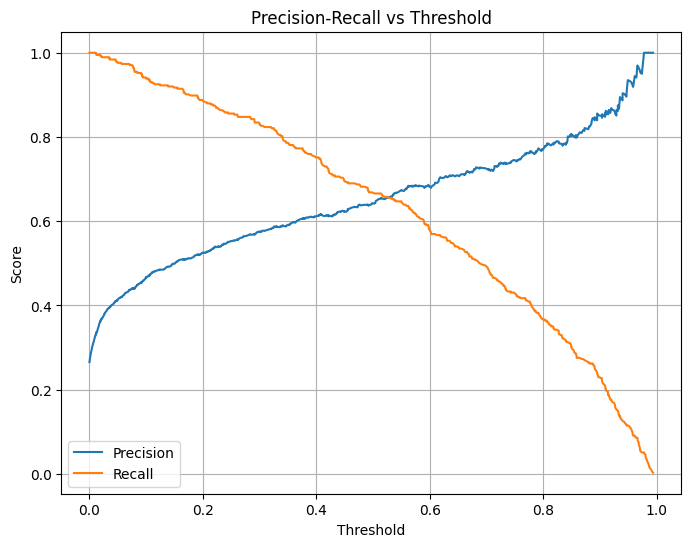


 best threshold (max F1): 0.325

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1035
           1       0.59      0.82      0.68       374

    accuracy                           0.80      1409
   macro avg       0.76      0.81      0.77      1409
weighted avg       0.83      0.80      0.81      1409

ROC-AUC Score: 0.8815


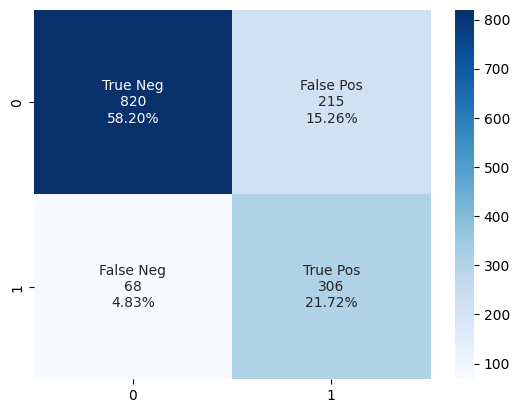

In [9]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Auto-select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")